# RTC System Data
## Import Libraries

In [1]:
# Upgrade command
!pip install --upgrade pip

# Install Requests
!pip install requests

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1.1)


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
import json
import requests
import datetime
import time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from collections import namedtuple
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib.pyplot import figure

### Latitude, Longitude & TZ

In [3]:
# Specify Location (Albuquerque, NM)
latitude, longitude, tz = 35, -106.6, 'US/Mountain'

## Accessing API with Pandas
### Weather and System Data

In [4]:
# Get Weather Data from URL - June 20
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/weather/start/2020-06-20/end/2020-06-21/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
weather_df = pd.DataFrame(response.json())
weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,RainDailyAccumilation,RelativeHumidity,TmStamp,WindDirection,WindSpeed
0,22.670000,-8.005275,-0.048687,-6.629228,0.0,14.04,1592611260000,25.559999,1.143
1,22.780001,-7.651270,-0.039072,-6.592465,0.0,13.57,1592611320000,31.350000,1.144
2,22.809999,-7.494656,-0.144552,-6.635629,0.0,13.65,1592611380000,62.419998,0.727
3,22.740000,-7.627976,-0.075786,-6.628935,0.0,14.08,1592611440000,52.630001,1.050
4,22.650000,-6.595940,0.146353,-6.573357,0.0,14.26,1592611500000,37.849998,1.074


In [5]:
# Drop unnecessary data
weather_df.drop(['RainDailyAccumilation', 'RelativeHumidity', 'WindDirection', 'WindSpeed'], axis=1, inplace=True)

weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,TmStamp
0,22.670000,-8.005275,-0.048687,-6.629228,1592611260000
1,22.780001,-7.651270,-0.039072,-6.592465,1592611320000
2,22.809999,-7.494656,-0.144552,-6.635629,1592611380000
3,22.740000,-7.627976,-0.075786,-6.628935,1592611440000
4,22.650000,-6.595940,0.146353,-6.573357,1592611500000


In [6]:
weather_df.rename(columns={'TmStamp':'TimeStamp', 'GlobalIrrad':'GHI', 'DirectIrrad':'DNI', 'DiffuseIrrad':'DHI'}, inplace=True)

In [7]:
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,22.670000,-8.005275,-0.048687,-6.629228,1592611260000
1,22.780001,-7.651270,-0.039072,-6.592465,1592611320000
2,22.809999,-7.494656,-0.144552,-6.635629,1592611380000
3,22.740000,-7.627976,-0.075786,-6.628935,1592611440000
4,22.650000,-6.595940,0.146353,-6.573357,1592611500000


In [8]:
# Examine the types of the column labels
all(isinstance(column, str) for column in weather_df.columns)

True

In [9]:
weather_df['TimeStamp'] =  pd.to_datetime(weather_df['TimeStamp']/1000, unit='s')
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,22.670000,-8.005275,-0.048687,-6.629228,2020-06-20 00:01:00
1,22.780001,-7.651270,-0.039072,-6.592465,2020-06-20 00:02:00
2,22.809999,-7.494656,-0.144552,-6.635629,2020-06-20 00:03:00
3,22.740000,-7.627976,-0.075786,-6.628935,2020-06-20 00:04:00
4,22.650000,-6.595940,0.146353,-6.573357,2020-06-20 00:05:00


In [10]:
# TimeStamp as Index
weather_df.set_index('TimeStamp', inplace=True)
weather_df.head()

,AmbientTemp,DHI,DNI,GHI
TimeStamp,,,,
2020-06-20 00:01:00,22.670000,-8.005275,-0.048687,-6.629228
2020-06-20 00:02:00,22.780001,-7.651270,-0.039072,-6.592465
2020-06-20 00:03:00,22.809999,-7.494656,-0.144552,-6.635629
2020-06-20 00:04:00,22.740000,-7.627976,-0.075786,-6.628935
2020-06-20 00:05:00,22.650000,-6.595940,0.146353,-6.573357


In [11]:
# Weather Keys
print("Keys of weather_df: \n{}".format(weather_df.keys()))

Keys of weather_df: 
Index(['AmbientTemp', 'DHI', 'DNI', 'GHI'], dtype='object')


In [12]:
# Analyzing Data - June 20
# Global Horizonal & Direct Normal(W/m*2)
# Air Temperature (deg C)
weather_df.describe()

,AmbientTemp,DHI,DNI,GHI
count,1439.000000,1439.000000,1439.000000,1439.000000
mean,26.818756,43.729531,442.002126,358.545450
std,4.574820,46.624721,419.857884,403.151139
min,19.910000,-11.933796,-0.879314,-7.600715
25%,22.170000,-6.287882,0.113453,-4.992969
50%,26.559999,51.783314,483.987915,160.148575
75%,31.270000,89.018684,893.735077,769.691040
max,34.820000,108.325531,970.594055,1047.201782


In [13]:
weather_df_slice = weather_df.iloc[::5] 

## System

In [14]:
# Get System Data from URL - June 20
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/system/start/2020-06-20/end/2020-06-21/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
system_df = pd.DataFrame(response.json())
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TmStamp
0,21.675001,-2.317497,0.0,0.0,-0.045,2.2,-2.422635,0.006,1.733333,0.0,1592611260000
1,21.650000,-1.834685,0.0,0.0,-0.045,2.2,-2.642775,0.006,1.650000,0.0,1592611320000
2,21.591665,-1.255311,0.0,0.0,-0.045,2.2,-2.569559,0.006,1.733333,0.0,1592611380000
3,21.558332,-1.641560,0.0,0.0,-0.045,2.2,-2.643424,0.006,1.666667,0.0,1592611440000
4,21.533333,-1.158749,0.0,0.0,-0.045,2.2,-2.496970,0.006,1.700000,0.0,1592611500000


In [15]:
# System Keys
print("Keys of system_df: \n{}".format(system_df.keys()))

Keys of system_df: 
Index(['AmbientTemp', 'PyranometerIrrad', 'RefCell1Irrad', 'RefCell2Irrad',
       'Sys1Idc', 'Sys1Vdc', 'Sys1Wac', 'Sys2Idc', 'Sys2Vdc', 'Sys2Wac',
       'TmStamp'],
      dtype='object')


In [16]:
system_df.rename(columns={'TmStamp':'TimeStamp'}, inplace=True)

In [17]:
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,21.675001,-2.317497,0.0,0.0,-0.045,2.2,-2.422635,0.006,1.733333,0.0,1592611260000
1,21.650000,-1.834685,0.0,0.0,-0.045,2.2,-2.642775,0.006,1.650000,0.0,1592611320000
2,21.591665,-1.255311,0.0,0.0,-0.045,2.2,-2.569559,0.006,1.733333,0.0,1592611380000
3,21.558332,-1.641560,0.0,0.0,-0.045,2.2,-2.643424,0.006,1.666667,0.0,1592611440000
4,21.533333,-1.158749,0.0,0.0,-0.045,2.2,-2.496970,0.006,1.700000,0.0,1592611500000


In [18]:
system_df.tail()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
1434,23.116667,-2.317497,0.0,0.0,-0.045,2.4,-2.644405,0.006,1.8,0.0,1592697300000
1435,23.133333,-2.607184,0.0,0.0,-0.045,2.4,-2.203754,0.006,1.8,0.0,1592697360000
1436,23.000000,-2.414059,0.0,0.0,-0.045,2.4,-2.424434,0.006,1.8,0.0,1592697420000
1437,22.991667,-2.414059,0.0,0.0,-0.045,2.4,-2.350721,0.006,1.8,0.0,1592697480000
1438,22.991667,-2.510622,0.0,0.0,-0.045,2.4,-2.351060,0.006,1.8,0.0,1592697540000


In [19]:
# Examine the types of the column labels
all(isinstance(column, str) for column in system_df.columns)

True

In [20]:
system_df['TimeStamp'] =  pd.to_datetime(system_df['TimeStamp']/1000, unit='s')
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,21.675001,-2.317497,0.0,0.0,-0.045,2.2,-2.422635,0.006,1.733333,0.0,2020-06-20 00:01:00
1,21.650000,-1.834685,0.0,0.0,-0.045,2.2,-2.642775,0.006,1.650000,0.0,2020-06-20 00:02:00
2,21.591665,-1.255311,0.0,0.0,-0.045,2.2,-2.569559,0.006,1.733333,0.0,2020-06-20 00:03:00
3,21.558332,-1.641560,0.0,0.0,-0.045,2.2,-2.643424,0.006,1.666667,0.0,2020-06-20 00:04:00
4,21.533333,-1.158749,0.0,0.0,-0.045,2.2,-2.496970,0.006,1.700000,0.0,2020-06-20 00:05:00


In [21]:
system_df.drop(system_df.index[range(0, 340)], axis=0, inplace=True)

In [22]:
system_df.drop(system_df.index[range(1019, 1099)], axis=0, inplace=True)

In [23]:
# TimeStamp as Index
system_df.set_index('TimeStamp', inplace=True)
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-06-20 05:41:00,19.850000,31.962145,31.997065,31.310228,0.21475,326.299988,56.763630,0.24825,350.916656,66.660942
2020-06-20 05:42:00,19.883333,32.444958,32.484306,31.764799,0.22025,323.716644,58.520100,0.24700,355.549957,65.924751
2020-06-20 05:43:00,19.866667,33.120892,32.987225,32.278660,0.22500,323.399994,59.785625,0.25200,355.250000,67.627594
2020-06-20 05:44:00,19.791666,33.603706,33.414040,32.762897,0.22950,322.266663,61.263676,0.25450,356.283325,69.183968
2020-06-20 05:45:00,19.775000,34.086517,33.962143,33.188869,0.23275,325.799988,62.734913,0.25975,355.966644,70.362595


In [24]:
# Analyzing Data
system_df.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000
mean,28.296385,439.712923,425.477304,423.132677,3.481990,271.027997,1075.324105,3.505693,271.093567,1104.117163
std,4.019091,379.419061,376.136426,375.972466,3.098724,125.658077,931.444941,3.070331,131.425200,946.961280
min,19.216667,-4.634994,0.000000,0.000000,-0.043250,2.383333,-4.111516,0.006000,1.600000,0.000000
25%,25.508332,35.534954,36.664068,35.931892,0.257625,310.458328,68.967598,0.278750,312.791687,75.930248
50%,28.966667,417.728851,387.040680,381.704010,3.191750,321.350006,1053.994751,3.203500,324.983307,1083.899780
75%,31.862499,826.525635,814.641876,812.456329,6.678750,337.649994,2050.674316,6.684374,344.574997,2094.677002
max,34.149998,1018.346863,1000.668396,998.101318,8.066500,405.549957,2374.745850,8.032750,373.599976,2432.138428


In [25]:
system_df_slice = system_df.iloc[::5] 

In [26]:
system_df_slice.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-06-20 05:41:00,19.850000,31.962145,31.997065,31.310228,0.21475,326.299988,56.763630,0.24825,350.916656,66.660942
2020-06-20 05:46:00,19.783335,34.762455,34.419285,33.600220,0.23600,327.916656,64.713257,0.26450,356.266632,72.413734
2020-06-20 05:51:00,19.741667,41.908070,36.855335,35.845852,0.25925,327.466644,71.837227,0.27800,361.199982,78.876740
2020-06-20 05:56:00,19.300001,46.349934,39.046898,37.987328,0.28025,327.666656,78.886665,0.29350,364.016632,84.817932
2020-06-20 06:01:00,19.291666,49.826183,41.039070,39.893349,0.28550,344.399994,85.569267,0.31850,361.233307,92.823845


In [27]:
system_df_slice.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,28.268954,439.486600,425.296086,422.808473,3.478328,271.504816,1074.568938,3.502995,271.810615,1103.427414
std,4.040888,380.298140,376.970771,376.924662,3.104549,125.576543,933.759544,3.076722,131.228318,949.122374
min,19.291666,-4.634994,0.000000,0.000000,-0.043000,2.400000,-2.790069,0.006000,1.600000,0.000000
25%,25.604166,35.559095,36.581934,35.713612,0.257188,310.220833,69.946440,0.277125,312.625000,77.154026
50%,29.016666,416.811478,384.688568,380.097092,3.187375,321.816681,1055.488770,3.189750,325.074997,1083.989868
75%,31.666666,825.994522,810.896774,811.397537,6.663000,337.583328,2044.911713,6.673312,344.799995,2091.334229
max,34.149998,1018.346863,1000.668396,998.101318,8.043500,404.433319,2374.745850,8.032750,372.949982,2424.618408


# Weather and System Plot
## Weather June 20

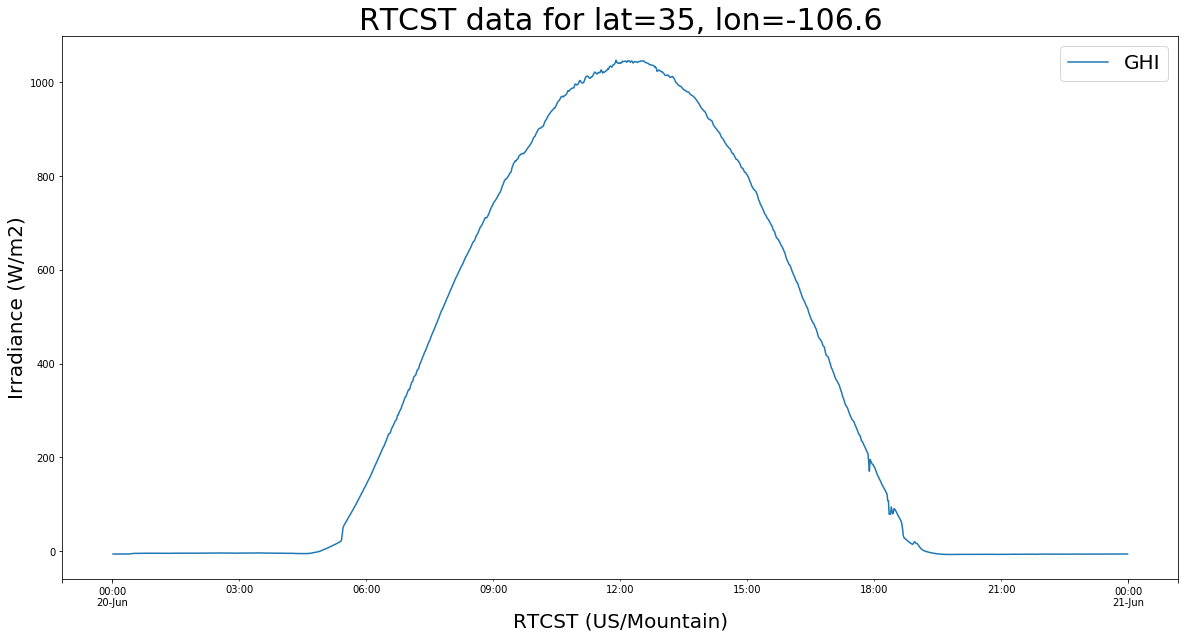

In [28]:
# Plot GHI
irrad_var = ['GHI']
weather_df[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

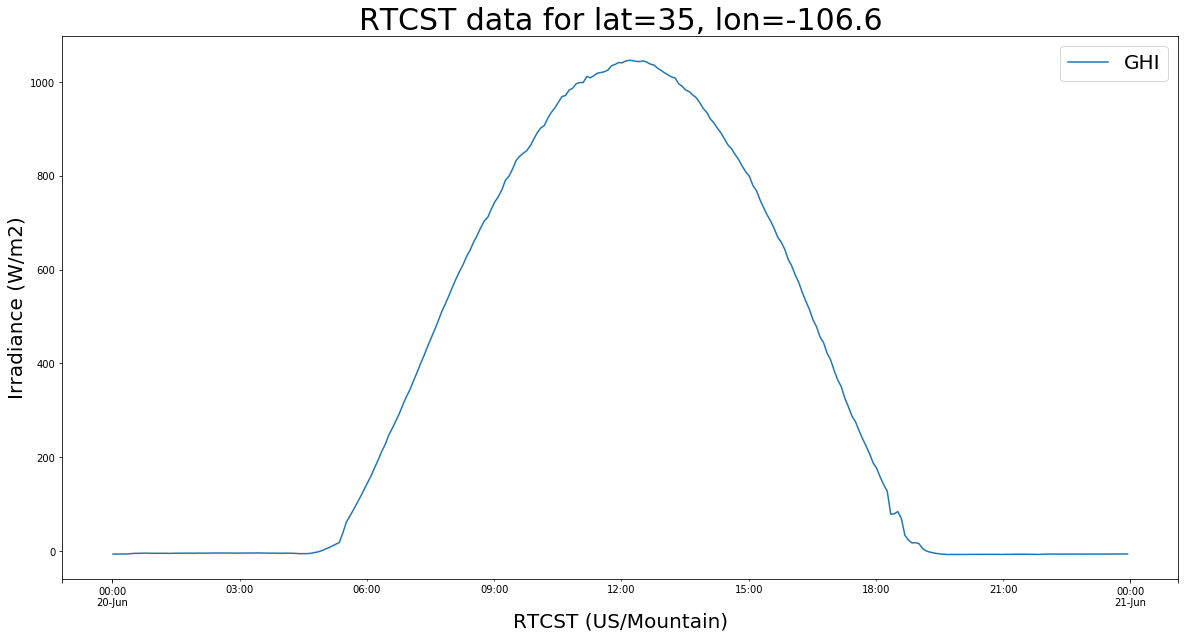

In [29]:
# Plot GHI
irrad_var = ['GHI']
weather_df_slice[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## System PIV June 20

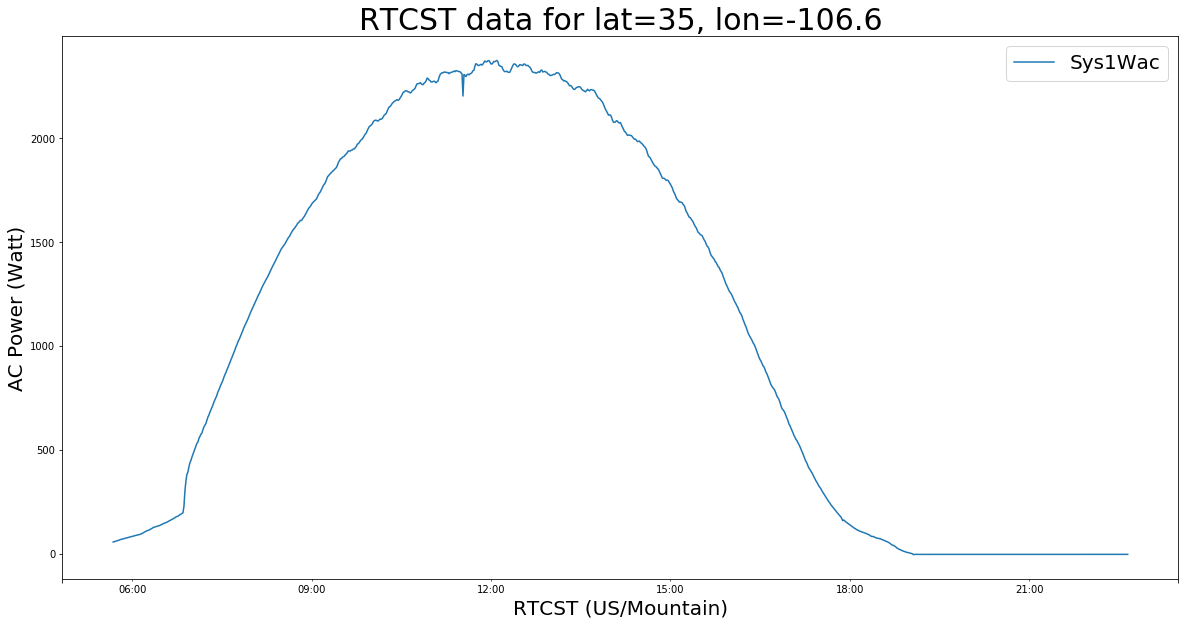

In [30]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

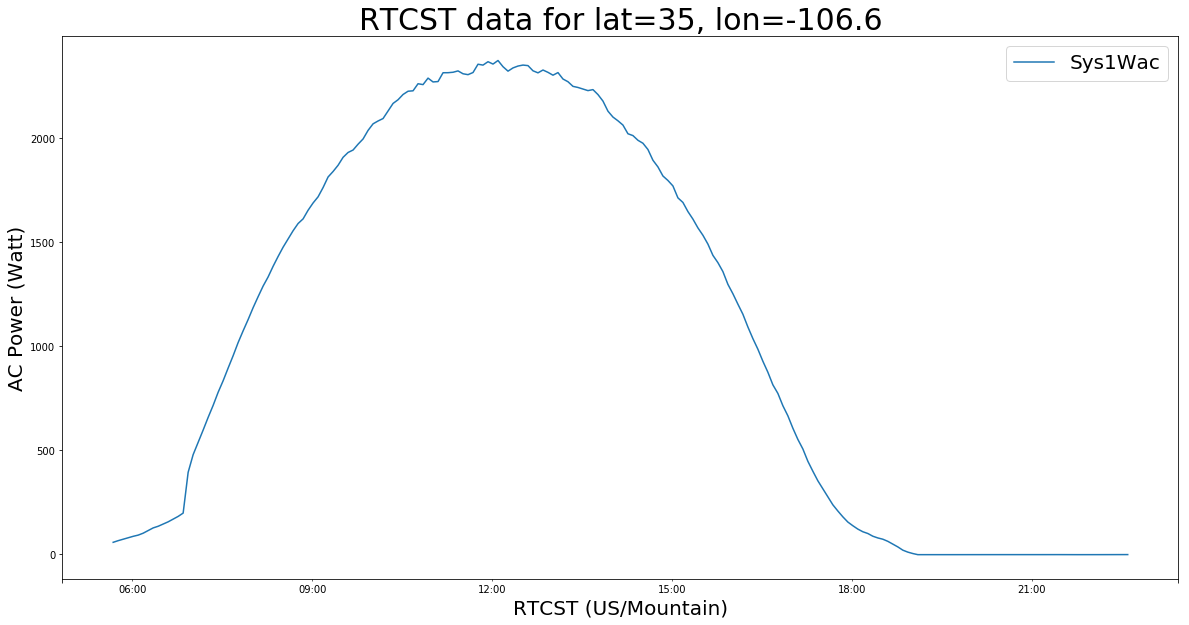

In [31]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

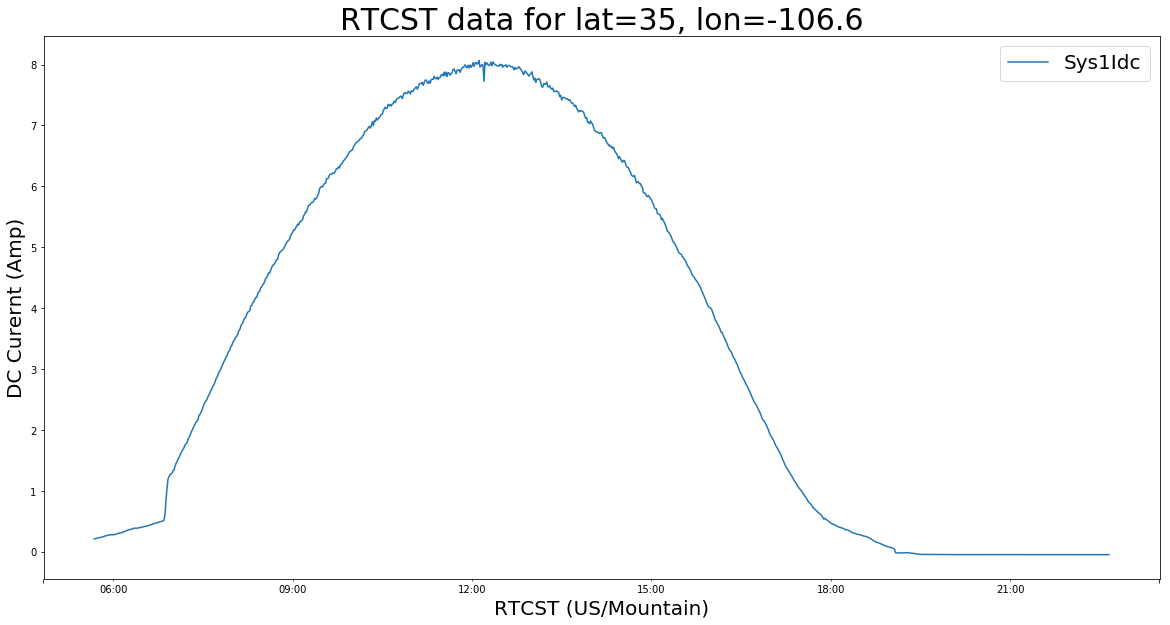

In [32]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

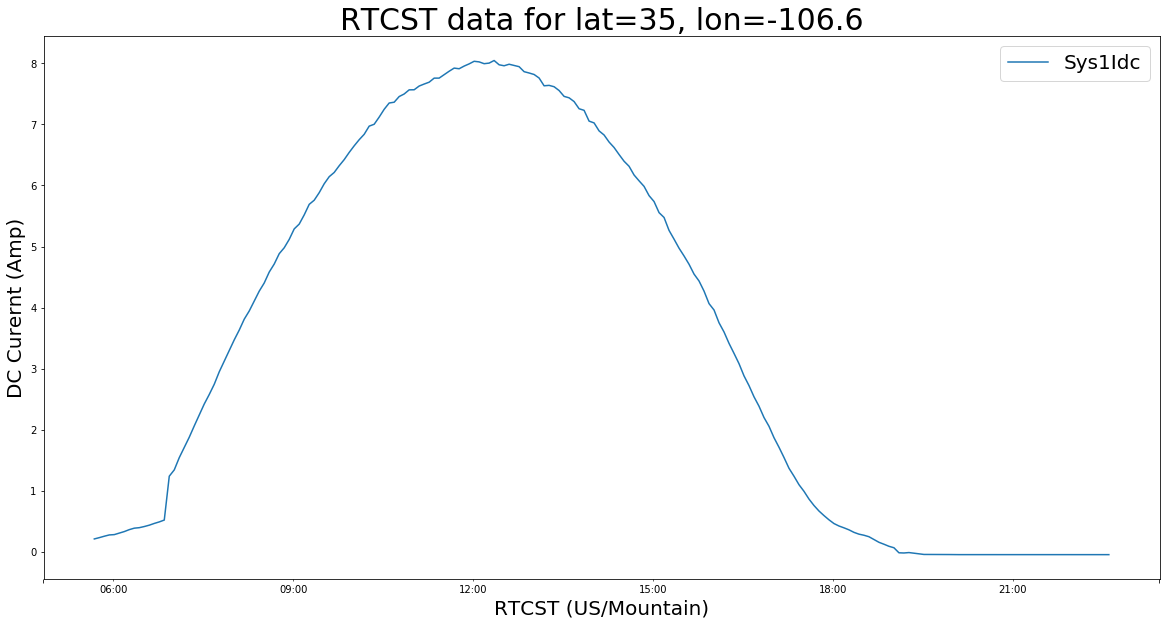

In [33]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

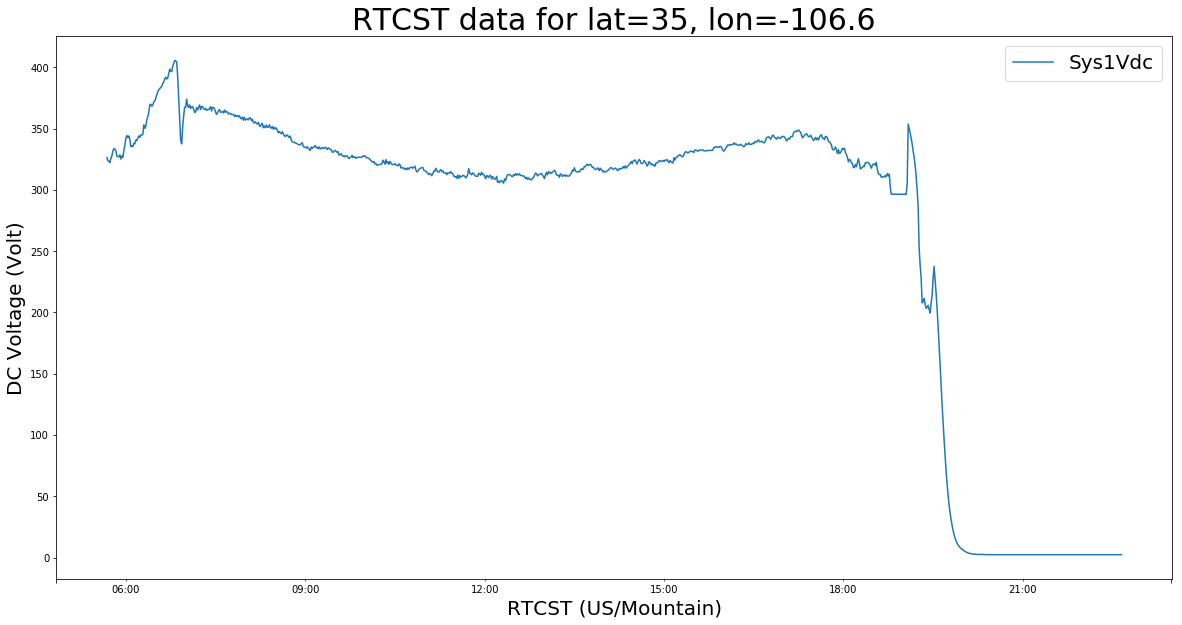

In [34]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

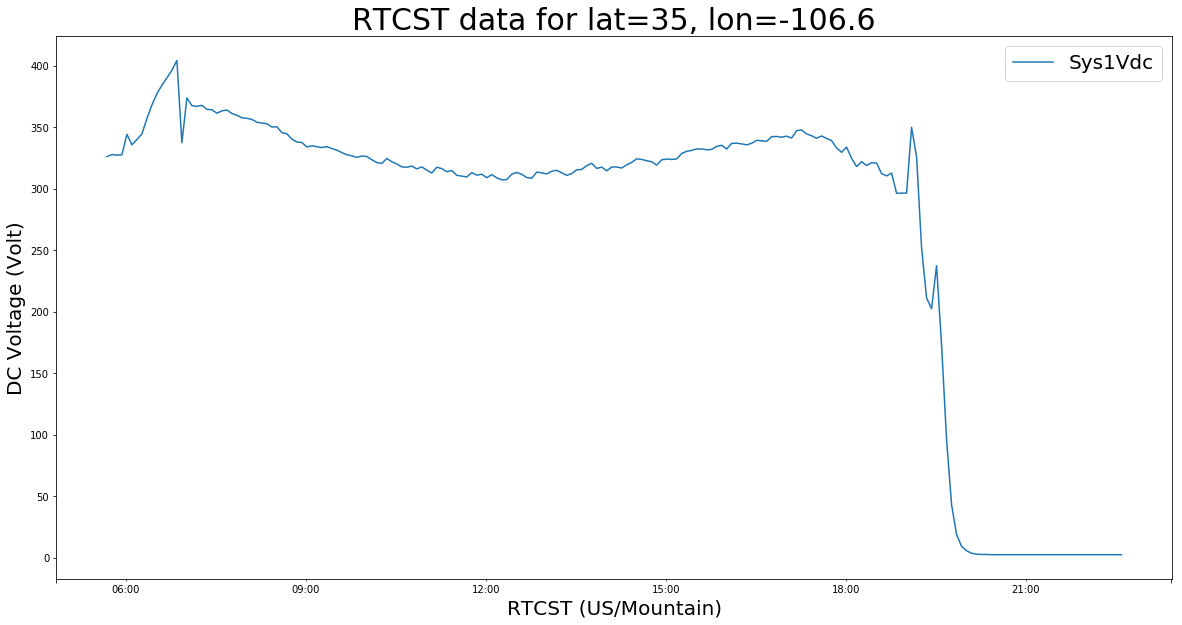

In [35]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df_slice[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## Read HRRR CSV's

In [36]:
# Read HRRR Irradiance CSV
hrrr_df = pd.read_csv('HRRR June 20.csv')
print("Keys of hrrr_df: \n{}".format(hrrr_df.keys()))

Keys of hrrr_df: 
Index(['Unnamed: 0', 'ghi', 'dni', 'dhi'], dtype='object')


In [37]:
hrrr_df.describe()

,ghi,dni,dhi
count,18.000000,18.000000,18.000000
mean,450.967147,458.233861,122.269051
std,381.841111,318.601861,100.588796
min,0.000000,0.000000,0.000000
25%,37.870163,65.221864,24.725774
50%,449.678140,658.588917,108.258492
75%,818.682367,711.115063,207.702565
max,972.536057,727.934223,282.620711


In [38]:
hrrr_df.head()

,Unnamed: 0,ghi,dni,dhi
0,2020-06-20 06:00:00-06:00,0.369237,0.000000,0.369237
1,2020-06-20 07:00:00-06:00,117.801073,260.887455,65.223518
2,2020-06-20 08:00:00-06:00,320.138035,564.437067,96.160722
3,2020-06-20 09:00:00-06:00,522.864286,697.253992,118.035273
4,2020-06-20 10:00:00-06:00,702.184085,726.947564,163.966736


In [39]:
# Read Forecast AC Power CSV
ac_df = pd.read_csv('HRRR AC June 20.csv')
print("Keys of ac_df: \n{}".format(ac_df.keys()))

Keys of ac_df: 
Index(['2020-06-20 06:00:00-06:00', '-1.56'], dtype='object')


In [40]:
ac_df.head()

,2020-06-20 06:00:00-06:00,-1.56
0,2020-06-20 06:05:00-06:00,-1.560000
1,2020-06-20 06:10:00-06:00,-1.560000
2,2020-06-20 06:15:00-06:00,-1.560000
3,2020-06-20 06:20:00-06:00,-1.560000
4,2020-06-20 06:25:00-06:00,-8.358183


In [41]:
# TimeStamp as Index
ac_df.set_index('2020-06-20 06:00:00-06:00', inplace=True)
ac_df.head()

,-1.56
2020-06-20 06:00:00-06:00,
2020-06-20 06:05:00-06:00,-1.560000
2020-06-20 06:10:00-06:00,-1.560000
2020-06-20 06:15:00-06:00,-1.560000
2020-06-20 06:20:00-06:00,-1.560000
2020-06-20 06:25:00-06:00,-8.358183


In [42]:
ac_df.rename(columns={'-1.56':'AC Power'}, inplace=True)
ac_df.head()

,AC Power
2020-06-20 06:00:00-06:00,
2020-06-20 06:05:00-06:00,-1.560000
2020-06-20 06:10:00-06:00,-1.560000
2020-06-20 06:15:00-06:00,-1.560000
2020-06-20 06:20:00-06:00,-1.560000
2020-06-20 06:25:00-06:00,-8.358183


In [43]:
ac_df.describe()

,AC Power
count,204.000000
mean,1212.552069
std,965.735296
min,-8.358183
25%,85.855370
50%,1300.750212
75%,2192.462183
max,2499.828308


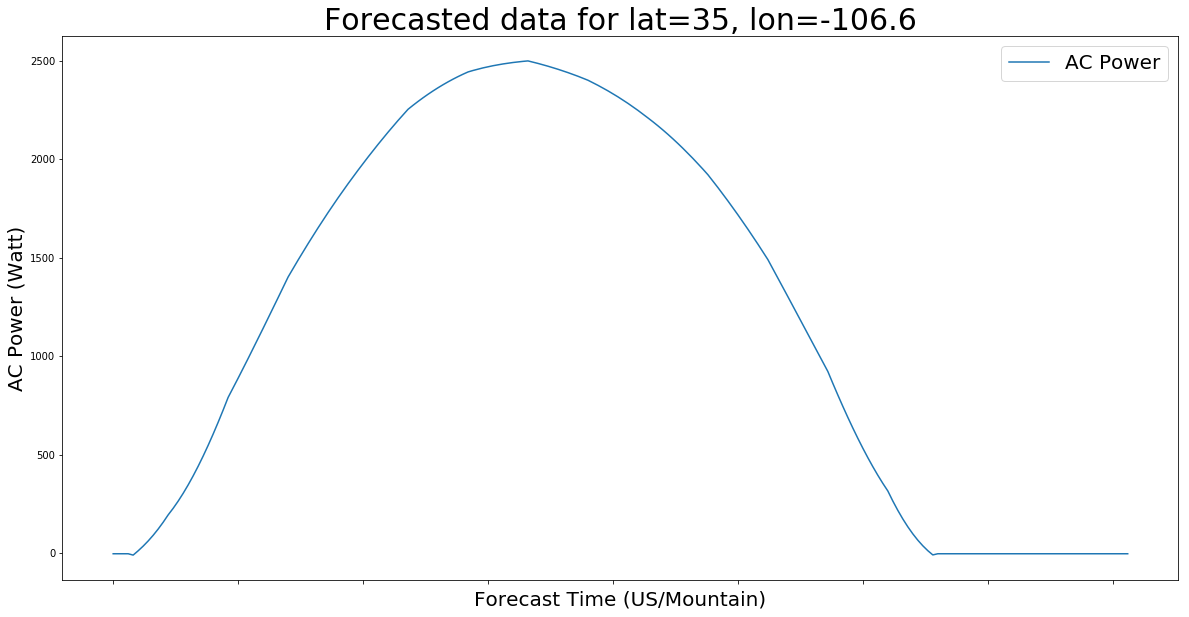

In [44]:
# Plot AC Power
forecast_ac = ['AC Power']
ac_df[forecast_ac].plot(figsize=(20,10), label = 'AC Power');
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Forecast Time ({})'.format(tz),size=20);
plt.title('Forecasted data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [45]:
# Read Forecast DC Power CSV
dc_df = pd.read_csv('HRRR DC June 20.csv')
print("Keys of dc_df: \n{}".format(dc_df.keys()))

Keys of dc_df: 
Index(['Unnamed: 0', 'i_sc', 'i_mp', 'v_oc', 'v_mp', 'p_mp', 'i_x', 'i_xx'], dtype='object')


In [46]:
dc_df.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,2.388872,2.131813,606.229835,483.615512,1294.670459,2.332757,1.554113
std,1.869885,1.663430,291.724972,237.432210,1006.508432,1.827072,1.186120
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317367,0.286485,691.840300,540.431817,148.806995,0.309155,0.227685
50%,2.480547,2.222803,747.329476,599.975338,1404.002550,2.419996,1.677699
75%,4.294330,3.829772,764.283218,614.296966,2311.580352,4.194781,2.756624
max,4.901965,4.359417,773.896611,637.432910,2631.736561,4.790311,3.091223


In [47]:
dc_df.head()

,Unnamed: 0,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
0,2020-06-20 06:00:00-06:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-06-20 06:05:00-06:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-06-20 06:10:00-06:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-06-20 06:15:00-06:00,0.062808,0.05687,638.874375,402.870967,22.911144,0.061172,0.045364
4,2020-06-20 06:20:00-06:00,0.113575,0.10282,666.318881,468.865234,48.208843,0.110621,0.081921


### Merge DataFrames

In [48]:
# Clear Index
ac_df=ac_df.reset_index()
system_df_slice=system_df_slice.reset_index()

In [49]:
ac_df.head()

,2020-06-20 06:00:00-06:00,AC Power
0,2020-06-20 06:05:00-06:00,-1.560000
1,2020-06-20 06:10:00-06:00,-1.560000
2,2020-06-20 06:15:00-06:00,-1.560000
3,2020-06-20 06:20:00-06:00,-1.560000
4,2020-06-20 06:25:00-06:00,-8.358183


In [50]:
ac_df.describe()

,AC Power
count,204.000000
mean,1212.552069
std,965.735296
min,-8.358183
25%,85.855370
50%,1300.750212
75%,2192.462183
max,2499.828308


In [51]:
system_df_slice.head()

,TimeStamp,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
0,2020-06-20 05:41:00,19.850000,31.962145,31.997065,31.310228,0.21475,326.299988,56.763630,0.24825,350.916656,66.660942
1,2020-06-20 05:46:00,19.783335,34.762455,34.419285,33.600220,0.23600,327.916656,64.713257,0.26450,356.266632,72.413734
2,2020-06-20 05:51:00,19.741667,41.908070,36.855335,35.845852,0.25925,327.466644,71.837227,0.27800,361.199982,78.876740
3,2020-06-20 05:56:00,19.300001,46.349934,39.046898,37.987328,0.28025,327.666656,78.886665,0.29350,364.016632,84.817932
4,2020-06-20 06:01:00,19.291666,49.826183,41.039070,39.893349,0.28550,344.399994,85.569267,0.31850,361.233307,92.823845


In [52]:
system_df_slice.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,28.268954,439.486600,425.296086,422.808473,3.478328,271.504816,1074.568938,3.502995,271.810615,1103.427414
std,4.040888,380.298140,376.970771,376.924662,3.104549,125.576543,933.759544,3.076722,131.228318,949.122374
min,19.291666,-4.634994,0.000000,0.000000,-0.043000,2.400000,-2.790069,0.006000,1.600000,0.000000
25%,25.604166,35.559095,36.581934,35.713612,0.257188,310.220833,69.946440,0.277125,312.625000,77.154026
50%,29.016666,416.811478,384.688568,380.097092,3.187375,321.816681,1055.488770,3.189750,325.074997,1083.989868
75%,31.666666,825.994522,810.896774,811.397537,6.663000,337.583328,2044.911713,6.673312,344.799995,2091.334229
max,34.149998,1018.346863,1000.668396,998.101318,8.043500,404.433319,2374.745850,8.032750,372.949982,2424.618408


In [53]:
# I guess it will make plotting easier
system=system_df_slice['Sys1Wac']
ac_df['System']=system
ac_df.head()

,2020-06-20 06:00:00-06:00,AC Power,System
0,2020-06-20 06:05:00-06:00,-1.560000,56.763630
1,2020-06-20 06:10:00-06:00,-1.560000,64.713257
2,2020-06-20 06:15:00-06:00,-1.560000,71.837227
3,2020-06-20 06:20:00-06:00,-1.560000,78.886665
4,2020-06-20 06:25:00-06:00,-8.358183,85.569267


In [54]:
# TimeStamp as Index
ac_df.set_index('2020-06-20 06:00:00-06:00', inplace=True)
ac_df.head()

,AC Power,System
2020-06-20 06:00:00-06:00,,
2020-06-20 06:05:00-06:00,-1.560000,56.763630
2020-06-20 06:10:00-06:00,-1.560000,64.713257
2020-06-20 06:15:00-06:00,-1.560000,71.837227
2020-06-20 06:20:00-06:00,-1.560000,78.886665
2020-06-20 06:25:00-06:00,-8.358183,85.569267


In [55]:
# Examine the column labels
all(isinstance(column, str) for column in ac_df.columns)

True

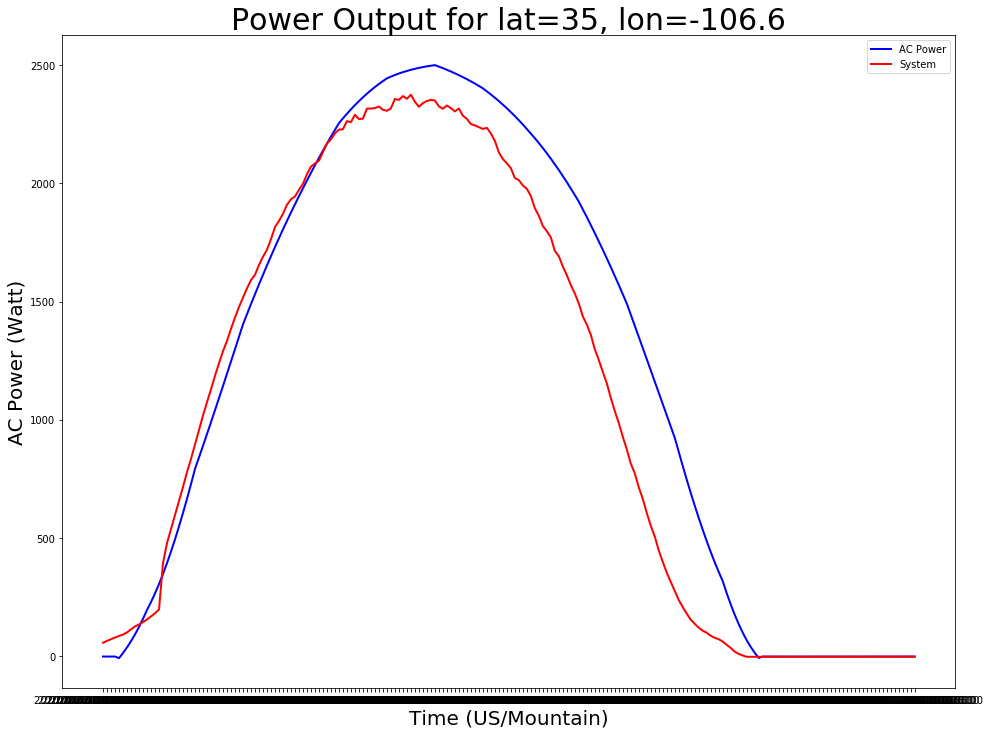

In [56]:
plt.figure(figsize=(16,12))
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Time ({})'.format(tz),size=20);
plt.title('Power Output for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.plot('AC Power', data=ac_df, marker='', color='blue', linewidth=2);
plt.plot('System', data=ac_df, marker='', color='red', linewidth=2);
plt.legend();

## Read NDFD CSV's

In [57]:
# Read NDFD Irradiance CSV
ndfd_df = pd.read_csv('NDFD June 20.csv')
print("Keys of ndfd_df: \n{}".format(ndfd_df.keys()))

Keys of ndfd_df: 
Index(['Unnamed: 0', 'ghi', 'dni', 'dhi'], dtype='object')


In [58]:
ndfd_df.describe()

,ghi,dni,dhi
count,19.000000,19.000000,19.000000
mean,404.058939,351.729414,150.671991
std,366.762431,266.701875,133.899437
min,0.000000,0.000000,0.000000
25%,5.455105,0.000000,5.455105
50%,354.467194,502.316448,129.198976
75%,744.553195,585.507783,273.256911
max,934.607118,603.139972,357.055744


In [59]:
ndfd_df.head()

,Unnamed: 0,ghi,dni,dhi
0,2020-06-20 06:00:00-06:00,0.340437,0.000000,0.340437
1,2020-06-20 07:00:00-06:00,108.612581,195.880951,69.136012
2,2020-06-20 08:00:00-06:00,295.167246,438.007953,121.358951
3,2020-06-20 09:00:00-06:00,485.479456,551.620123,165.206167
4,2020-06-20 10:00:00-06:00,651.977878,569.010463,230.693982


In [60]:
# Read Forecast AC Power CSV
ac_ndfd = pd.read_csv('NDFD AC June 20.csv')
print("Keys of ac_ndfd: \n{}".format(ac_ndfd.keys()))

Keys of ac_ndfd: 
Index(['2020-06-20 06:00:00-06:00', '-1.56'], dtype='object')


In [61]:
ac_ndfd.head()

,2020-06-20 06:00:00-06:00,-1.56
0,2020-06-20 06:05:00-06:00,-1.560000
1,2020-06-20 06:10:00-06:00,-1.560000
2,2020-06-20 06:15:00-06:00,-1.560000
3,2020-06-20 06:20:00-06:00,-1.560000
4,2020-06-20 06:25:00-06:00,-7.233546


In [62]:
# TimeStamp as Index
ac_ndfd.set_index('2020-06-20 06:00:00-06:00', inplace=True)
ac_ndfd.head()

,-1.56
2020-06-20 06:00:00-06:00,
2020-06-20 06:05:00-06:00,-1.560000
2020-06-20 06:10:00-06:00,-1.560000
2020-06-20 06:15:00-06:00,-1.560000
2020-06-20 06:20:00-06:00,-1.560000
2020-06-20 06:25:00-06:00,-7.233546


In [63]:
ac_ndfd.rename(columns={'-1.56':'AC Power'}, inplace=True)
ac_ndfd.head()

,AC Power
2020-06-20 06:00:00-06:00,
2020-06-20 06:05:00-06:00,-1.560000
2020-06-20 06:10:00-06:00,-1.560000
2020-06-20 06:15:00-06:00,-1.560000
2020-06-20 06:20:00-06:00,-1.560000
2020-06-20 06:25:00-06:00,-7.233546


In [64]:
ac_ndfd.describe()

,AC Power
count,216.000000
mean,1109.516964
std,962.415759
min,-7.490308
25%,-1.560000
50%,1078.273290
75%,2073.823611
max,2504.081524


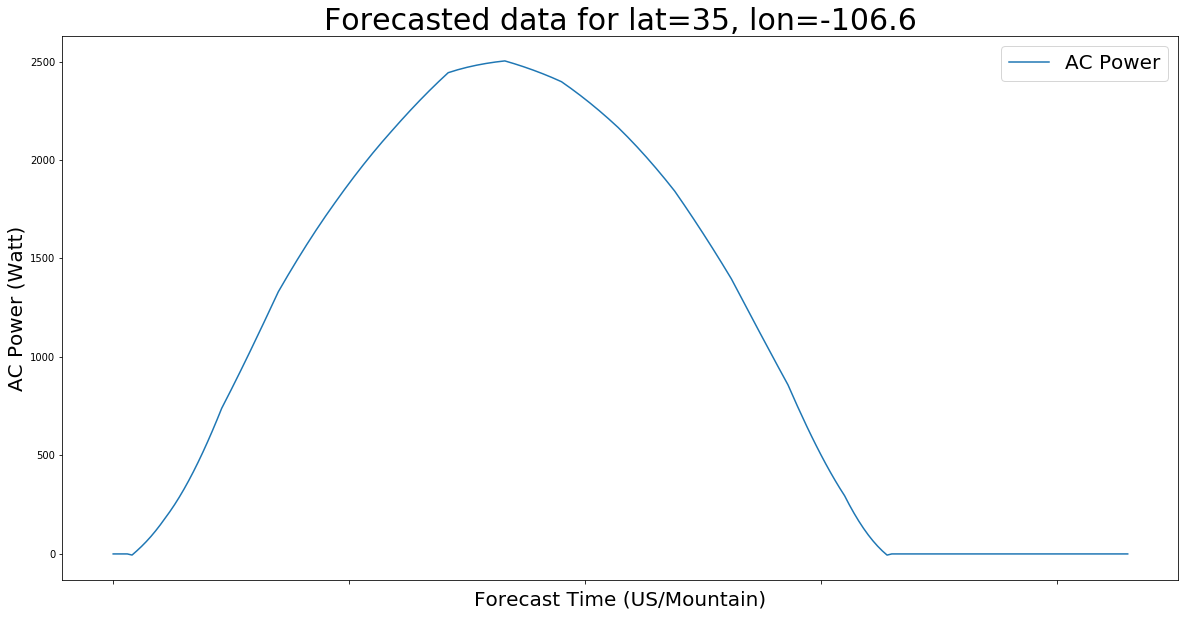

In [65]:
# Plot AC Power
ndfd_ac = ['AC Power']
ac_ndfd[ndfd_ac].plot(figsize=(20,10), label = 'AC Power');
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Forecast Time ({})'.format(tz),size=20);
plt.title('Forecasted data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [66]:
# Read Forecast DC Power CSV
dc_ndfd = pd.read_csv('NDFD DC June 20.csv')
print("Keys of dc_ndfd: \n{}".format(dc_ndfd.keys()))

Keys of dc_ndfd: 
Index(['Unnamed: 0', 'i_sc', 'i_mp', 'v_oc', 'v_mp', 'p_mp', 'i_x', 'i_xx'], dtype='object')


In [67]:
dc_ndfd.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,2.134187,1.907539,578.008789,463.297667,1187.844100,2.083771,1.396358
std,1.797310,1.602530,319.432079,260.946605,1006.117350,1.755816,1.149614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.117264,0.106104,631.162248,418.539990,47.374989,0.114214,0.084574
50%,2.097785,1.881270,749.647890,606.906073,1178.152951,2.046032,1.434104
75%,3.931023,3.508053,781.696310,634.611690,2187.992626,3.838914,2.550930
max,4.696290,4.185968,788.903616,651.699787,2639.865506,4.588716,2.978440


In [68]:
dc_ndfd.head()

,Unnamed: 0,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
0,2020-06-20 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-06-20 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-06-20 06:10:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-06-20 06:15:00-06:00,0.065283,0.059078,631.162248,394.489456,23.305615,0.063582,0.047149
4,2020-06-20 06:20:00-06:00,0.117264,0.106104,659.151537,461.113168,48.926095,0.114214,0.084574


### Merge DataFrames

In [69]:
# Clear Index
ac_ndfd=ac_ndfd.reset_index()

In [70]:
ac_ndfd.head()

,2020-06-20 06:00:00-06:00,AC Power
0,2020-06-20 06:05:00-06:00,-1.560000
1,2020-06-20 06:10:00-06:00,-1.560000
2,2020-06-20 06:15:00-06:00,-1.560000
3,2020-06-20 06:20:00-06:00,-1.560000
4,2020-06-20 06:25:00-06:00,-7.233546


In [71]:
ac_ndfd.describe()

,AC Power
count,216.000000
mean,1109.516964
std,962.415759
min,-7.490308
25%,-1.560000
50%,1078.273290
75%,2073.823611
max,2504.081524


In [72]:
# I guess it will make plotting easier
system=system_df_slice['Sys1Wac']
ac_ndfd['System']=system
ac_ndfd.head()

,2020-06-20 06:00:00-06:00,AC Power,System
0,2020-06-20 06:05:00-06:00,-1.560000,56.763630
1,2020-06-20 06:10:00-06:00,-1.560000,64.713257
2,2020-06-20 06:15:00-06:00,-1.560000,71.837227
3,2020-06-20 06:20:00-06:00,-1.560000,78.886665
4,2020-06-20 06:25:00-06:00,-7.233546,85.569267


In [73]:
# TimeStamp as Index
ac_ndfd.set_index('2020-06-20 06:00:00-06:00', inplace=True)
ac_ndfd.head()

,AC Power,System
2020-06-20 06:00:00-06:00,,
2020-06-20 06:05:00-06:00,-1.560000,56.763630
2020-06-20 06:10:00-06:00,-1.560000,64.713257
2020-06-20 06:15:00-06:00,-1.560000,71.837227
2020-06-20 06:20:00-06:00,-1.560000,78.886665
2020-06-20 06:25:00-06:00,-7.233546,85.569267


In [74]:
# Examine the column labels
all(isinstance(column, str) for column in ac_ndfd.columns)

True

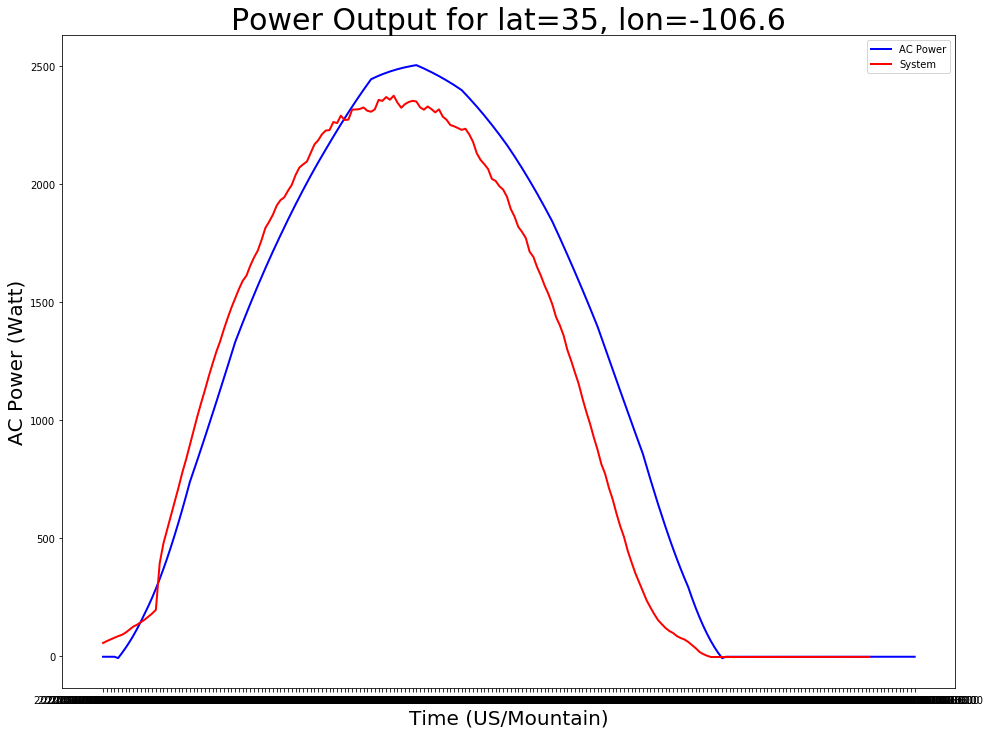

In [75]:
plt.figure(figsize=(16,12))
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Time ({})'.format(tz),size=20);
plt.title('Power Output for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.plot('AC Power', data=ac_ndfd, marker='', color='blue', linewidth=2);
plt.plot('System', data=ac_ndfd, marker='', color='red', linewidth=2);
plt.legend();

## Error
### Mean Square Error

In [76]:
y_true= system_df_slice['Sys1Wac']
y_pred= ac_df['AC Power']
print('Mean Square Error:\n',mean_squared_error(y_true, y_pred))

Mean Square Error:
 70691.9384170139
